# Write Final Results

Write the averaged model predictions as NetCDF4 file.

In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import xarray as xr

from deepwaters.utils import ROOT_DIR, month_center_range

In [2]:
preds = xr.open_zarr(
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr"
)
preds

<xarray.Dataset> Size: 4GB
Dimensions:                                    (lat: 360, lon: 720, time: 973)
Coordinates:
  * lat                                        (lat) float32 1kB 89.75 ... -8...
  * lon                                        (lon) float32 3kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 8kB 1940...
Data variables:
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>

## Convert coordinates

Convert the geospatial coordinates to GRACE style:

- lat: 90 to -90 → -90 to 90
- lon: -180 to 180 → 0 to 360

In [3]:
preds = preds.assign_coords(lon=(preds.lon) % 360).sortby("lon")
preds = preds.reindex(lat=-preds.lat)
preds

<xarray.Dataset> Size: 4GB
Dimensions:                                    (lat: 360, time: 973, lon: 720)
Coordinates:
  * lat                                        (lat) float32 1kB -89.75 ... 8...
  * time                                       (time) datetime64[ns] 8kB 1940...
  * lon                                        (lon) float32 3kB 0.25 ... 359.8
Data variables:
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>

Move timestamps to month centers:

In [4]:
preds_time = preds.get_index("time")
preds_time_center = month_center_range(preds_time[0], preds_time[-1])

preds = preds.assign(time=preds_time_center)
preds

<xarray.Dataset> Size: 4GB
Dimensions:                                    (lat: 360, lon: 720, time: 973)
Coordinates:
  * lat                                        (lat) float32 1kB -89.75 ... 8...
  * lon                                        (lon) float32 3kB 0.25 ... 359.8
  * time                                       (time) datetime64[ns] 8kB 1940...
Data variables:
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 1GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>

Convert data variables from millimeters to centimeters:

In [5]:
preds = preds * 0.1

## Define attributes

Attribute convention according to [ESIP Attribute Convention for Data Discovery](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3).

In [6]:
timeformat = "%Y-%m-%dT%H:%M:%SZ"
timenow_str = pd.Timestamp.utcnow().strftime(timeformat)

timestart_str = preds_time_center[0].strftime(timeformat)
timeend_str = preds_time_center[-1].strftime(timeformat)

preds_lat = preds.get_index("lat")
preds_lon = preds.get_index("lon")
latmin = preds_lat[0]
latmax = preds_lat[-1]
lonmin = preds_lon[0]
lonmax = preds_lon[-1]

In [7]:
title_nogap = "DeepWaters_TWSA-Rec_CSR_ERA5-HI"
title_gap = "DeepWaters_TWSA-Rec_CSR_WGHM-ERA5-HI"

In [8]:
era5_vars = {
    "d2m",
    "t2m",
    "e",
    "cvh",
    "cvl",
    "lai_hv",
    "lai_lv",
    "pev",
    "sro",
    "ssro",
    "sp",
    "tp",
    "swvl1",
    "swvl2",
    "swvl3",
    "swvl4",
}
era5_vars_str = ", ".join(era5_vars)
era5_vars_str

'd2m, sp, t2m, lai_lv, cvl, swvl1, ssro, swvl3, cvh, pev, swvl2, swvl4, e, sro, tp, lai_hv'

In [9]:
input_nogap = (
    f"ERA5 single levels monthly means ({era5_vars_str}), "
    + "ISIMIP land use (irrigated cropland, rainfed cropland, pastures, urban areas), ISIMIP lake area fraction, "
    + "NOAA ERSSTv5 Oceanic Niño Index"
)
input_gap = "WaterGAP v2.2e 20CRv3-ERA5 TWS, " + input_nogap

input_gap

'WaterGAP v2.2e 20CRv3-ERA5 TWS, ERA5 single levels monthly means (d2m, sp, t2m, lai_lv, cvl, swvl1, ssro, swvl3, cvh, pev, swvl2, swvl4, e, sro, tp, lai_hv), ISIMIP land use (irrigated cropland, rainfed cropland, pastures, urban areas), ISIMIP lake area fraction, NOAA ERSSTv5 Oceanic Niño Index'

In [10]:
nogap_attrs = {
    "Conventions": "ACDD-1.3",
    "title": title_nogap,
    "summary": "Reconstructed GRACE TWS anomalies using CSR mascon solutions as target",
    "keywords": "GRACE, gravity, terrestrial water storage anomaly",
    "institution": "Institute of Geodesy and Photogrammetry, ETH Zurich, Switzerland",
    "creator_name": "Luis Gentner",
    "creator_email": "luis.gentner@outlook.com",
    "creator_type": "person",
    "time_coverage_start": timestart_str,
    "time_coverage_end": timeend_str,
    "time_coverage_resolution": "P1M",
    "geospatial_lat_min": latmin,
    "geospatial_lat_max": latmax,
    "geospatial_lat_units": "degree_north",
    "geospatial_lat_resolution": "0.5 degree",
    "geospatial_lon_min": lonmin,
    "geospatial_lon_max": lonmax,
    "geospatial_lon_units": "degree_east",
    "geospatial_lon_resolution": "0.5 degree",
    "model_target": "CSR GRACE/GRACE-FO RL06.2 mascon solutions with all corrections",
    "model_input": input_nogap,
    "date_created": timenow_str,
    "comment": "The ground truth of this reconstruction, the CSR GRACE RL0602 mascon product, "
    + "was downsampled to 0.5° before it was used as input. "
    + "Only grid cells were reconstructed that are considered as land "
    + "by both JPL and GSFC mascon land masks and are not part of Greenland or Antarctica.",
}

In [11]:
gap_attrs = deepcopy(nogap_attrs)
gap_attrs["title"] = title_gap
gap_attrs["model_input"] = input_gap

In [12]:
time_attrs = {
    "standard_name": "time",
    "long_name": "Time",
    "axis": "T",
    "coverage_content_type": "coordinate",
}
lat_attrs = {
    "standard_name": "latitude",
    "long_name": "Latitude",
    "units": "degrees_north",
    "axis": "Y",
    "coverage_content_type": "coordinate",
}

lon_attrs = {
    "standard_name": "longitude",
    "long_name": "Longitude",
    "units": "degrees_east",
    "axis": "X",
    "coverage_content_type": "coordinate",
}

In [13]:
twsa_attrs = {
    "standard_name": "liquid_water_equivalent_thickness",
    "long_name": "Terrestrial water storage anomaly",
    "units": "cm",
    "coverage_content_type": "modelResult",
}
sigma_attrs = {
    "standard_name": "uncertainty",
    "long_name": "Predictive uncertainty standard deviation",
    "units": "cm",
    "comment": "1-sigma predictive uncertainty, obtained using a deep ensemble with 10 members",
    "coverage_content_type": "modelResult",
}

## Set attributes

In [14]:
preds.time.attrs = time_attrs
preds.lat.attrs = lat_attrs
preds.lon.attrs = lon_attrs

In [15]:
twsa_nogap = preds.pred_ensemble_alltrain_nogap_lnll_latest.rename("lwe_thickness")
twsa_gap = preds.pred_ensemble_alltrain_gap_lnll_latest.rename("lwe_thickness")

sigma_nogap = preds.sigma_ensemble_alltrain_nogap_lnll_latest.rename("uncertainty")
sigma_gap = preds.sigma_ensemble_alltrain_gap_lnll_latest.rename("uncertainty")

twsa_nogap.attrs = twsa_attrs
twsa_gap.attrs = twsa_attrs

sigma_nogap.attrs = sigma_attrs
sigma_gap.attrs = sigma_attrs

Create individual datasets:

In [16]:
ds_nogap = xr.merge([twsa_nogap, sigma_nogap])
ds_gap = xr.merge([twsa_gap, sigma_gap])

ds_nogap.attrs = nogap_attrs
ds_gap.attrs = gap_attrs

## Set encoding

In [17]:
encoding = {"zlib": True, "complevel": 6}
time_encoding = {
    "dtype": np.dtype("int32"),
    "units": "hours since 1901-01-01T00:00:00Z",
    "calendar": "gregorian",
}

ds_gap.time.encoding = time_encoding
ds_nogap.time.encoding = time_encoding

ds_gap = ds_gap.dw.set_var_encoding("all", **encoding)
ds_nogap = ds_nogap.dw.set_var_encoding("all", **encoding)

## Write files

In [18]:
out_dir = ROOT_DIR / "models/final-products"
out_dir.mkdir(parents=True, exist_ok=True)
netcdf_kwargs = {"mode": "w", "format": "NETCDF4", "engine": "h5netcdf"}

ds_nogap.to_netcdf(out_dir / title_nogap, **netcdf_kwargs)
ds_gap.to_netcdf(out_dir / title_gap, **netcdf_kwargs)

## Check files

In [19]:
ds_nogap = xr.open_dataset(out_dir / title_nogap)
ds_gap = xr.open_dataset(out_dir / title_gap)

In [20]:
ds_nogap

<xarray.Dataset> Size: 2GB
Dimensions:        (lat: 360, lon: 720, time: 973)
Coordinates:
  * lat            (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon            (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * time           (time) datetime64[ns] 8kB 1940-12-16T12:00:00 ... 2021-12-...
Data variables:
    lwe_thickness  (time, lat, lon) float32 1GB ...
    uncertainty    (time, lat, lon) float32 1GB ...
Attributes: (12/23)
    Conventions:                ACDD-1.3
    title:                      DeepWaters_TWSA-Rec_CSR_ERA5-HI
    summary:                    Reconstructed GRACE TWS anomalies using CSR m...
    keywords:                   GRACE, gravity, terrestrial water storage ano...
    institution:                Institute of Geodesy and Photogrammetry, ETH ...
    creator_name:               Luis Gentner
    ...                         ...
    geospatial_lon_units:       degree_east
    geospatial_lon_resolution:  0.5 degree
    model_target:               CSR GRACE/GRACE-FO RL06.2 mascon solutions wi...
    model_input:                ERA5 single levels monthly means (d2m, sp, t2...
    date_created:               2024-07-10T13:16:25Z
    comment:                    The ground truth of this reconstruction, the ...

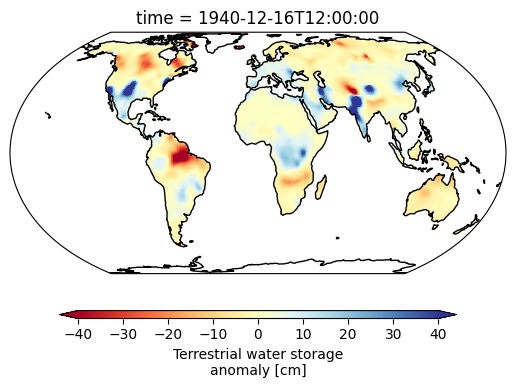

In [34]:
plot_kwargs = {"vmin": -40, "vmax": 40, "coastlines": True}

ds_gap.lwe_thickness.isel(time=0).dw.projplot(**plot_kwargs);


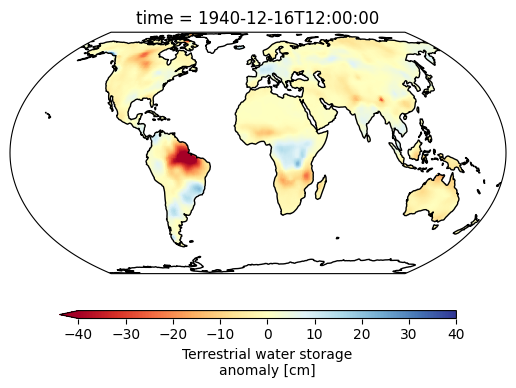

In [35]:
ds_nogap.lwe_thickness.isel(time=0).dw.projplot(**plot_kwargs);